In [1]:
import numpy as np
import pandas as pd
from scipy import stats
import sys
import argparse
import h5py
from scipy.stats import t as student_t
from statsmodels.stats import multitest as mt
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [2]:
subjects_to_be_ignored = [21269692]
subject_sex = 'female'
prototype_flag = True

deconfound_flag = True
# if deconfound_flag == True:
#     import matlab.engine
#     eng = matlab.engine.start_matlab()
    
IDP_cuttoff_nan = 1.0
vars_cutoff_nan = 0.1

In [3]:
# Identify Correct File to Load

IDP_file = 'female_testB_IDPs.h5'
confounds_file = 'female_testB_conf12.h5'
data_file = 'female_testB.pkl'

confounds = h5py.File(confounds_file, 'r')
confounds = confounds['conf12'][()]

IDP_h5 = h5py.File(IDP_file, 'r')
subjects_h5 = IDP_h5['subjects'][()]

# Load the relevant dataframe based on the required modality

df = pd.read_pickle(data_file)

IDP_h5 = h5py.File(IDP_file, 'r')
IDPs_i_deconf = IDP_h5['IDPs1_i_deconf'][()]
vars_i_deconf = IDP_h5['vars_i_deconf'][()]
subjects_h5 = IDP_h5['subjects'][()]

# Useful Functions

# def deconfound_inputs(deltas):
    
#     confounds = h5py.File('ICA/male_test_conf12.h5', 'r')
#     confounds = confounds['conf12'][()]
    
#     deltas_deconfounds = eng.NetsUnconfoundWrapper(eng.transpose(matlab.double(deltas.tolist())), 
#                                   matlab.double(confounds.tolist()))
    
#     deltas_deconfounds = np.asarray(deltas_deconfounds).flatten()
    
#     return deltas_deconfounds

def deconfound_inputs(y):
    
    y = y - y.mean(axis=0)
    if np.sum(np.isnan(y)) == 0:
        beta = np.linalg.pinv(confounds).dot(y)
        beta[np.abs(beta) < 1e-10] = 0
        yd = y - confounds.dot(beta)
        yd = yd - yd.mean()
    else:
        print('ERROR! Encoundered a NaN! Function Needs Updating!')
    
    return yd

def apply_FDR_correction(p_values):
    '''
    Code addapted from Emma Bluemke & Nicola Dinsdale
    Wrapper for Benjamini/Hochberg (non-negative) p-value correction for multiple tests.
    '''
    p_values_corrected = mt.multipletests(p_values, alpha=0.05, method='fdr_bh')[1] 
    
    return p_values_corrected


def standardize_data(variables):
    '''
    Code addapted from Emma Bluemke & Nicola Dinsdale
    '''

    number_of_subjects=variables.shape[0]

    # Compute the arithmetic mean & std along the specified axis, ignoring NaNs.
    variables_mean_ignore_NaNs = np.nanmean(variables,axis=0)
    variables_std_ignore_NaNs = np.nanstd(variables,axis=0)

    # We standardize the data
    variables_scaled = variables - np.tile(variables_mean_ignore_NaNs,(number_of_subjects,1))
    variables_scaled = variables_scaled / np.tile(variables_std_ignore_NaNs,(number_of_subjects,1))

    # Calculate how many variables are non NaN
    number_of_non_NaN =np.sum(np.isnan(variables)==False,axis=0) #np.nanstd has N**0.5 in divisor

    return variables_scaled, number_of_non_NaN


def correlate_with_fdr_correction(deltas, ukb_variables):
    """
    Code addapted from Emma Bluemke & Nicola Dinsdale

    correlate age deltas with rows in ukb_variables
    returns pearson_r, t_test_statistic, p_values_corrected, p_values of length number_of_variables

    pearson_r = raw Pearson correlation value (between -1 and 1)
    t_test_statistic t test statistic for each variable ()
    p_values_corrected is corrected p-values values (fdr corrected)
    p_values is non corrected p-values
    """

    ukb_variables_scaled , ukb_variales_number_of_non_NaN = standardize_data(ukb_variables)
    ukb_variables_NaN_matrix = np.isnan(ukb_variables_scaled)
    ukb_variables_scaled[ukb_variables_NaN_matrix] = 0

    sys.stdout.flush()

    number_of_variables = ukb_variables_scaled.shape[1]

    deltas_array = np.tile(deltas,(number_of_variables,1)).T
    deltas_array[ukb_variables_NaN_matrix] = np.nan
    deltas_array = standardize_data(deltas_array)[0]
    deltas_array[ukb_variables_NaN_matrix] = 0

    pearson_r = np.sum(deltas_array * ukb_variables_scaled, axis=0) / ukb_variales_number_of_non_NaN
    
    t_test_statistic = pearson_r * ((ukb_variales_number_of_non_NaN-2)/(1-pearson_r**2))**0.5
    t_test_statistic = np.abs(t_test_statistic)
    t_test_statistic[ukb_variales_number_of_non_NaN <= 2] = np.nan #set those that had d.o.f 0 to nan

    p_values=np.zeros(len(t_test_statistic))
    for j in range(len(t_test_statistic)):
        if t_test_statistic[j] is not np.nan:
            p_values[j] = student_t.sf(t_test_statistic[j], ukb_variales_number_of_non_NaN[j] - 2) * 2
        else:
            p_values[j]=np.nan

    p_values_NaN_matrix = np.isnan(p_values)
    p_values_no_NaN = p_values[p_values_NaN_matrix==False]
    p_values_corrected_raw = apply_FDR_correction(p_values_no_NaN)

    p_values_corrected=np.zeros(len(p_values))
    p_values_corrected[p_values_NaN_matrix==False] = p_values_corrected_raw
    p_values_corrected[p_values_NaN_matrix==True] = np.nan

    return pearson_r, t_test_statistic, p_values_corrected, p_values

def align_subjects(subjects_df, subjects_h5, age_delta_decon, subjects_to_be_ignored):
    '''
    Here we make sure that the subjects match between the results and the nIDP/IDP dataframes
    The subjects_df uses slightly older data, and subjects might have left the study since it's generation
    If need be, this will be corrected at a later stage!
    '''
    
    if len(subjects_df) == len(subjects_h5):
        assert (subjects_df == subjects_h5).all()
    else:
        idx_elim = np.where(subjects_df == subjects_to_be_ignored)[0][0]
        subjects_df = np.delete(subjects_df, idx_elim)
        assert (subjects_df == subjects_h5).all()
        age_delta_decon = np.delete(age_delta_decon, idx_elim)
    return subjects_df, age_delta_decon

def correlations_and_plots(age_delta_decon, deconf_subset, names_subset, idxs, categories_subset, title, 
                           corr_flag='IDP'):
    
    corr_results = correlate_with_fdr_correction(age_delta_decon, deconf_subset)
    
    corr_df = pd.DataFrame.from_dict({
        'idx': idxs,
        "names": names_subset,
        'Categories': categories_subset,
        "pearson_r": corr_results[0],
        "t_test_statistic": corr_results[1],
        "p_values_corrected": corr_results[2],
        "p_values": corr_results[3],
        "abs_pearson_r": np.abs(corr_results[0]),
        "log_p_values": -np.log10(corr_results[3]),
        "log_p_values_corrected": -np.log10(corr_results[2]),
    })
    
    if corr_flag == 'IDP':
        short_p_values = np.extract(corr_df.p_values !=0, corr_df.p_values)
        bonferroni_threshold = 0.05/len(short_p_values) #... Bonferroni
    else:
        bonferroni_threshold = 0.05/len(corr_df.p_values) #... Bonferroni
    bonferroni_threshold = -np.log10(bonferroni_threshold)

    arguments = np.argsort(corr_df.p_values_corrected)
    sorted_p_values_corrected = corr_df.p_values_corrected[arguments]
    sorted_p_values = corr_df.p_values[arguments]
    if len(sorted_p_values_corrected[sorted_p_values_corrected<=0.05]):
#         arguments_no_NaN = np.nanmax(sorted_p_values[sorted_p_values_corrected<=0.05])        
#         false_discovery_rate = sorted_p_values[arguments_no_NaN]

        false_discovery_rate = np.nanmax(sorted_p_values[sorted_p_values_corrected<=0.05])
        false_discovery_rate = -np.log10(false_discovery_rate)
        FDR_flag = True
    else:
        FDR_flag = False
        false_discovery_rate = None

    if corr_flag == 'IDP':
        x_text_location = -120
        bonferroni_threshold_text = 1
        false_discovery_rate_text = -2
        colorCycle = 'Paired'
    else:
        x_text_location = -750
        bonferroni_threshold_text = 0.1
        false_discovery_rate_text = -0.5
        colorCycle=['#000000', '#00CED1','#008080','#ffdf00','#9cded6','#8e063b','#DAACD5','#ff7f00','#8595e1','#e31a1c','#fb9a99','#0a5d00','#1fc600','#000080','#1f78b4','#a6cee3', '#023fa5', '#e07b91', '#50301e']
#         colorCycle=['#000000', '#00CED1','#008080','#ffdf00','#9cded6','#8e063b','#DAACD5','#ff7f00','#e31a1c','#fb9a99','#0a5d00','#1fc600','#000080','#1f78b4','#a6cee3', '#023fa5', '#e07b91', '#50301e']


    
    
    plt.figure(figsize=(16, 9.6))
    
    if corr_flag == 'IDP':
        sns.scatterplot(data=corr_df.sort_values('Categories'), x=np.arange(0,len(corr_df)), 
                    y='log_p_values', hue='Categories', 
                        palette=colorCycle
                       )
    else:
        sns.scatterplot(data=corr_df.sort_values('Categories'), x=np.arange(0,len(corr_df)), 
                    y='log_p_values', hue='Categories', 
                        palette=colorCycle
                       )  
    
    plt.ylabel('-log(P)')
    plt.tick_params(
        axis='x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom=False,      # ticks along the bottom edge are off
        top=False,         # ticks along the top edge are off
        labelbottom=False) # labels along the bottom edge are off
    plt.axhline(y = bonferroni_threshold, linestyle='--', color='r')
    plt.text(x=x_text_location, y=bonferroni_threshold + bonferroni_threshold_text, s='Bonf.')
    if false_discovery_rate is not None:
        plt.axhline(y = false_discovery_rate, linestyle='--', color='r')
        plt.text(x=x_text_location, y=false_discovery_rate + false_discovery_rate_text, s='FDR')
    plt.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.)
    plt.title(title)
    plt.show()
    
    return corr_df, bonferroni_threshold, false_discovery_rate



IDP_names = np.loadtxt("IDP_names.txt", dtype=str, delimiter='\n')
IDP_categories = np.loadtxt("IDP_categories.txt", dtype=str, delimiter='\n')
with open('varsHeader.txt') as f:
    varsHeader = f.readlines()
    varsHeader = [l.strip('\n\r') for l in varsHeader]
    varsHeader = np.array(varsHeader)
vars_categories = np.loadtxt("vars_categories.txt", dtype=str, delimiter='\n')

IDPIDX = np.arange(0, len(IDP_names), 1).astype(int)
varsIDX = np.arange(0, len(varsHeader), 1).astype(int)

# # Identify Correct File to Load

# data_file = 'male'
# IDP_file = 'male'
# if subject_sex == 'female':
#     data_file = 'fe' + data_file
#     IDP_file = 'fe' + IDP_file
# if prototype_flag == True:
#     data_file += '_prototype'
# data_file += '.pkl'
# IDP_file += '_test_IDPs.h5'

# # Load the relevant dataframe based on the required modality

# df = pd.read_pickle(data_file)

# IDP_h5 = h5py.File(IDP_file, 'r')
# IDPs_i_deconf = IDP_h5['IDPs1_i_deconf'][()]
# vars_i_deconf = IDP_h5['vars_i_deconf'][()]
# subjects_h5 = IDP_h5['subjects'][()]

# Filter out those IDPs and Vars which have too many NaNs (see 7.1 for more details!)

IDP_perc_not_nan = np.sum(np.isnan(IDPs_i_deconf)==False,axis=0) / IDPs_i_deconf.shape[0]
vars_perc_not_nan = np.sum(np.isnan(vars_i_deconf)==False,axis=0) / vars_i_deconf.shape[0]
IDP_idx_nan_cutoff = np.where(IDP_perc_not_nan >= IDP_cuttoff_nan)[0]
vars_idx_nan_cutoff = np.where(vars_perc_not_nan >= vars_cutoff_nan)[0]

IDP_names_subset = IDP_names[IDP_idx_nan_cutoff]
IDPs_i_deconf_subset = IDPs_i_deconf[:, IDP_idx_nan_cutoff]
IDP_categories_subset = IDP_categories[IDP_idx_nan_cutoff]
varsHeader_subset = varsHeader[vars_idx_nan_cutoff]
vars_i_deconf_subset = vars_i_deconf[:, vars_idx_nan_cutoff]
vars_categories_subset = vars_categories[vars_idx_nan_cutoff]
IDPIDX_subset = IDPIDX[IDP_idx_nan_cutoff]
varsIDX_subset = varsIDX[vars_idx_nan_cutoff]

del IDP_h5



TypeError: control character 'delimiter' cannot be a newline (`\r` or `\n`).

In [ ]:
df.head()

In [ ]:
df.iloc[0].dataframe

In [ ]:
np.unique(IDP_categories_subset)

In [ ]:
IDP_corrs = []
IDP_mods = []
IDP_bnf_thrs = []
IDP_fdr_thrs = []

for idx in range(len(df)):
    df_mod = df.iloc[idx].dataframe
    modality = df.iloc[idx].modality
    age_delta_decon = df_mod.age_delta_decon.to_numpy()
    subjects = df_mod['Unnamed: 0'].to_numpy()
    subjects, age_delta_decon = align_subjects(subjects, subjects_h5, 
                                                  age_delta_decon, subjects_to_be_ignored)
    if deconfound_flag == True:
        age_delta_decon = deconfound_inputs(age_delta_decon)
    
    corr_df, bonferroni_threshold, false_discovery_rate = correlations_and_plots(
                                    age_delta_decon = age_delta_decon, deconf_subset = IDPs_i_deconf_subset, 
                                    names_subset = IDP_names_subset, idxs = IDPIDX_subset,
                                    categories_subset = IDP_categories_subset,
                                    title = modality, corr_flag='IDP')
    IDP_mods.append(modality)
    IDP_corrs.append(corr_df)
    IDP_bnf_thrs.append(bonferroni_threshold)
    IDP_fdr_thrs.append(false_discovery_rate)
    
IDP_df = pd.DataFrame.from_dict({
    'modality': IDP_mods,
    'bonf': IDP_bnf_thrs,
    'fdr': IDP_fdr_thrs,
    'dataframe': IDP_corrs
})

In [18]:
IDP_df.to_pickle('female_IDP_testB.pkl', protocol = 4)

In [ ]:
vars_corrs = []
vars_mods = []
vars_bnf_thrs = []
vars_fdr_thrs = []

for idx in range(len(df)):
    df_mod = df.iloc[idx].dataframe
    modality = df.iloc[idx].modality
    age_delta_decon = df_mod.age_delta_decon.to_numpy()
    subjects = df_mod['Unnamed: 0'].to_numpy()
    subjects, age_delta_decon = align_subjects(subjects, subjects_h5, 
                                                  age_delta_decon, subjects_to_be_ignored)
    
    if deconfound_flag == True:
        age_delta_decon = deconfound_inputs(age_delta_decon)
        
        
    corr_df, bonferroni_threshold, false_discovery_rate = correlations_and_plots(
                                    age_delta_decon = age_delta_decon, deconf_subset = vars_i_deconf_subset, 
                                    names_subset = varsHeader_subset, idxs = varsIDX_subset,
                                    categories_subset = vars_categories_subset,
                                    title = modality, corr_flag='vars')
    vars_mods.append(modality)
    vars_corrs.append(corr_df)
    vars_bnf_thrs.append(bonferroni_threshold)
    vars_fdr_thrs.append(false_discovery_rate)
    
vars_df = pd.DataFrame.from_dict({
    'modality': vars_mods,
    'bonf': vars_bnf_thrs,
    'fdr': vars_fdr_thrs,
    'dataframe': vars_corrs
})

In [20]:
vars_df.to_pickle('female_vars_testB.pkl', protocol = 4)

In [21]:
# if deconfound_flag == True:
#     eng.quit()

In [22]:
# idp_df2 = IDP_df.iloc[np.where(IDP_df.modality=='swi')[0][0]].dataframe
# idp_df2[idp_df2.log_p_values>=idp_df2.bonferroni_threshold[0]].sort_values('log_p_values', ascending=False)

Plot the effect sizes (like R^2) for each significant hit. Have one plot in one view of associations. How much of the variace are we explaining the in the phenotype. 2 time point for longitudinal effects. 

In [18]:
def correlations_and_plots_replot(corr_df, bonferroni_threshold, false_discovery_rate, title,
                                 figsize,
                                  ticks_font_size,
                                  title_font_size,
                                  legend_font,
                                  save_title,
                                  ylabel = '-log(P)',
                                  legend_ncol = None
                                 ):


    colorCycle=['#000000', '#00CED1','#008080','#ffdf00','#9cded6','#8e063b','#DAACD5','#ff7f00','#8595e1','#e31a1c','#fb9a99','#0a5d00','#1fc600','#000080','#1f78b4','#a6cee3', '#023fa5', '#e07b91', '#50301e']
    x_text_location = -750
    bonferroni_threshold_text = 0.00429570699569 * corr_df.log_p_values.values.max()
    false_discovery_rate_text = - 0.03436565596552 * corr_df.log_p_values.values.max()


    fig = plt.figure(figsize=figsize)
    sns.scatterplot(data=corr_df.sort_values('Categories'), x=np.arange(0,len(corr_df)), 
                y='log_p_values', hue='Categories', palette=colorCycle)  

    plt.ylabel(ylabel, fontsize=title_font_size)
    plt.tick_params(
        axis='x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom=False,      # ticks along the bottom edge are off
        top=False,         # ticks along the top edge are off
        labelbottom=False) # labels along the bottom edge are off
    plt.axhline(y = bonferroni_threshold, linestyle='--', color='r',  linewidth = 2)
    plt.text(x=x_text_location, y=bonferroni_threshold + bonferroni_threshold_text, s='Bonf.', fontsize=legend_font)
    if false_discovery_rate is not None:
        plt.axhline(y = false_discovery_rate, linestyle='--', color='r',  linewidth = 2)
        plt.text(x=x_text_location, y=false_discovery_rate + false_discovery_rate_text, s='FDR', fontsize=legend_font)
    
    if legend_ncol == None:
        plt.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0., fontsize=legend_font)
    else:
        plt.legend(fontsize=legend_font, bbox_to_anchor=(0.5, -0.75), loc='lower center', ncol=legend_ncol)
    
    plt.title(title, fontsize=title_font_size)
    plt.xticks(fontsize= ticks_font_size)
    plt.yticks(fontsize= ticks_font_size)
    
    fig.savefig(save_title, bbox_inches='tight')

In [4]:
df = pd.read_pickle('female_vars_testB.pkl')

In [5]:
df

modality      bonf       fdr  \
0   T1_nonlinear  5.442009  3.767651   
1      T1_linear  5.442009  3.650484   
2       jacobian  5.442009  3.676520   
3            vbm  5.442009  3.632807   
4   T2_nonlinear  5.442009  4.016448   
5     T2_lesions  5.442009  4.619157   
6            swi  5.442009  3.622588   
7       rsfmri_0  5.442009  3.368398   
8       rsfmri_1  5.442009  3.426090   
9       rsfmri_2  5.442009  3.333374   
10      rsfmri_3  5.442009  3.400107   
11      rsfmri_4  5.442009  3.561070   
12      rsfmri_5  5.442009  3.522064   
13      rsfmri_6  5.442009  3.445930   
14      rsfmri_7  5.442009  3.309780   
15      rsfmri_8  5.442009  3.569325   
16      rsfmri_9  5.442009  3.451391   
17     rsfmri_10  5.442009  3.487095   
18     rsfmri_11  5.442009  3.387501   
19     rsfmri_12  5.442009  3.607726   
20     rsfmri_13  5.442009  3.409774   
21     rsfmri_14  5.442009  3.503705   
22     rsfmri_15  5.442009  3.601051   
23     rsfmri_16  5.442009  3.618352   
24     rsfmri_17  5.442009  3.464304   
25     rsfmri_18  5.442009  3.469570   
26     rsfmri_19  5.442009  3.719779   
27     rsfmri_20  5.442009  3.523820   
28     rsfmri_21  5.442009  3.345114   
29     rsfmri_22  5.442009  3.683584   
30     rsfmri_23  5.442009  3.526684   
31     rsfmri_24  5.442009  3.479470   
32       tfmri_1  5.442009  3.688751   
33       tfmri_2  5.442009  3.409500   
34       tfmri_5  5.442009  3.469468   
35     tfmri_c_1  5.442009  3.484851   
36     tfmri_c_2  5.442009  3.505516   
37     tfmri_c_5  5.442009  3.575311   
38        tracts  5.442009  3.419057   
39     tbss_FA_s  5.442009  3.490907   
40   tbss_ICVF_s  5.442009  3.661090   
41  tbss_ISOVF_s  5.442009  3.390313   
42     tbss_L1_s  5.442009  3.434943   
43     tbss_L2_s  5.442009  3.525551   
44     tbss_L3_s  5.442009  3.482338   
45     tbss_MD_s  5.442009  3.562129   
46     tbss_MO_s  5.442009  3.616127   
47     tbss_OD_s  5.442009  3.576423   
48       tbss_FA  5.442009  3.243128   
49     tbss_ICVF  5.442009  3.698838   
50    tbss_ISOVF  5.442009  3.478846   
51       tbss_L1  5.442009  3.433653   
52       tbss_L2  5.442009  3.518966   
53       tbss_L3  5.442009  3.459889   
54       tbss_MD  5.442009  3.452372   
55       tbss_MO  5.442009  3.634105   
56       tbss_OD  5.442009  3.399498   

                                            dataframe  
0            idx                                  ...  
1            idx                                  ...  
2            idx                                  ...  
3            idx                                  ...  
4            idx                                  ...  
5            idx                                  ...  
6            idx                                  ...  
7            idx                                  ...  
8            idx                                  ...  
9            idx                                  ...  
10           idx                                  ...  
11           idx                                  ...  
12           idx                                  ...  
13           idx                                  ...  
14           idx                                  ...  
15           idx                                  ...  
16           idx                                  ...  
17           idx                                  ...  
18           idx                                  ...  
19           idx                                  ...  
20           idx                                  ...  
21           idx                                  ...  
22           idx                                  ...  
23           idx                                  ...  
24           idx                                  ...  
25           idx                                  ...  
26           idx                                  ...  
27           idx                                  ...  
28           idx                                  ...  
29     

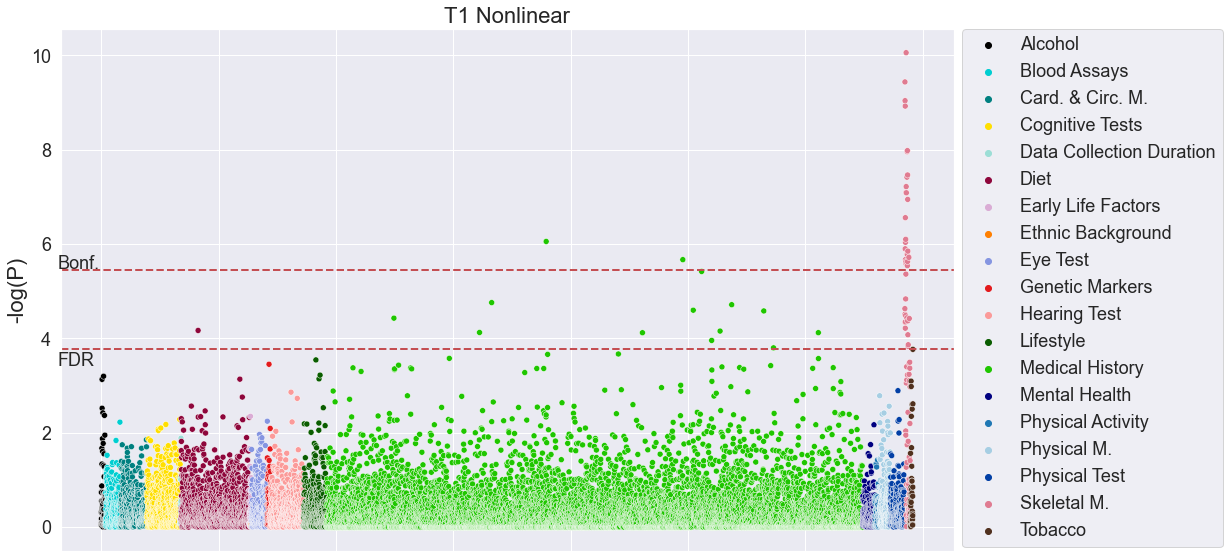

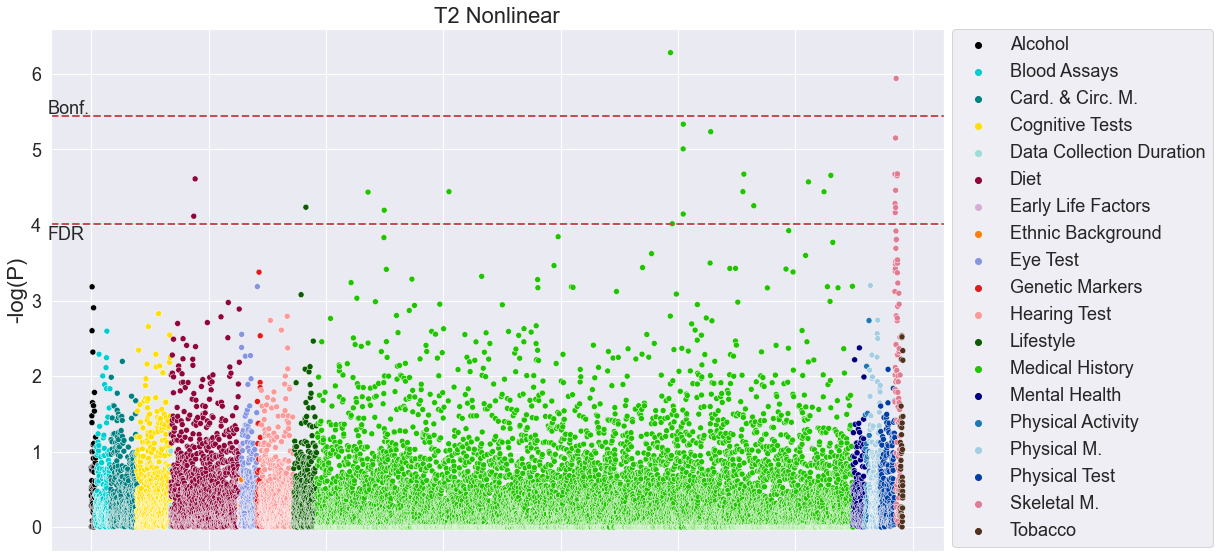

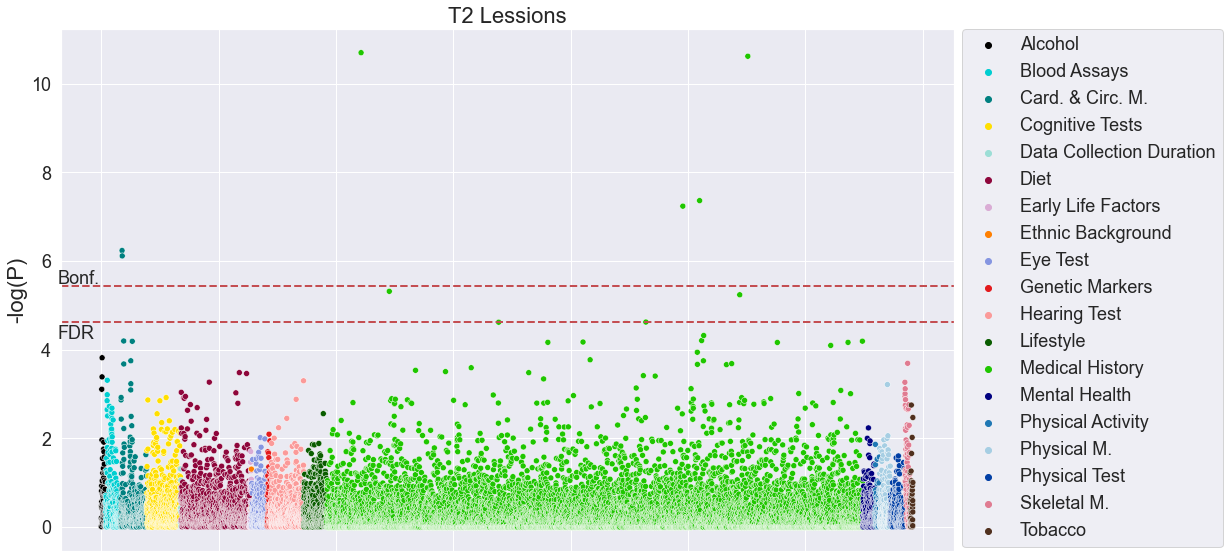

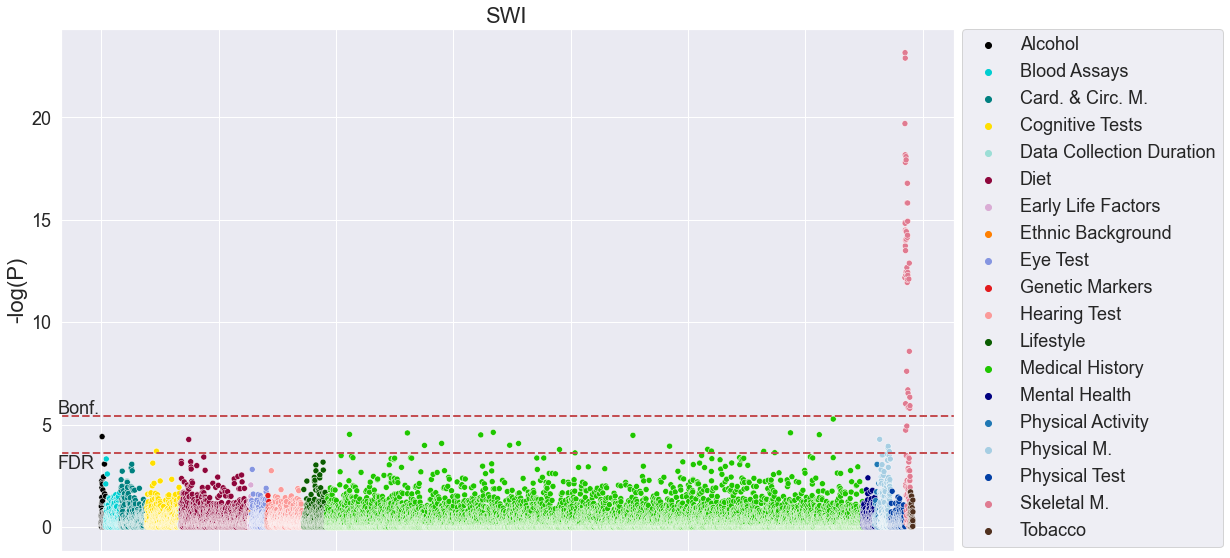

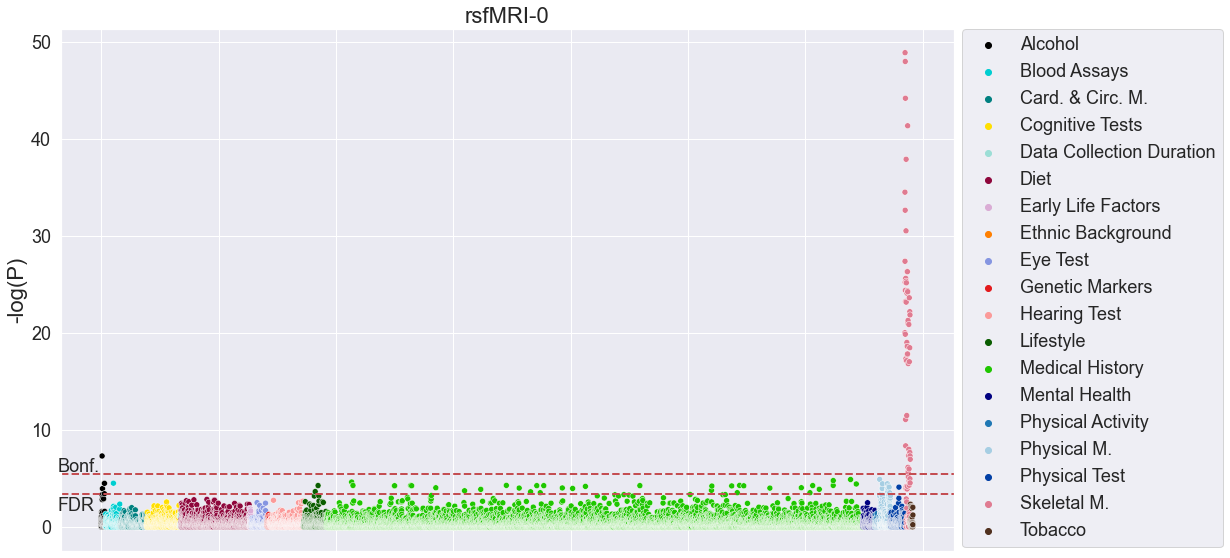

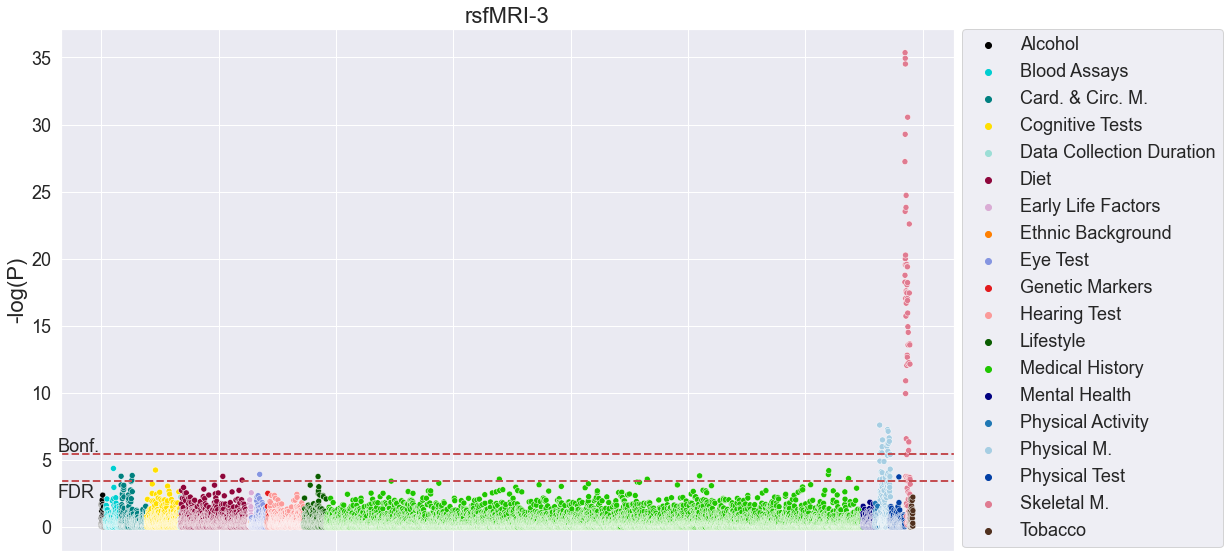

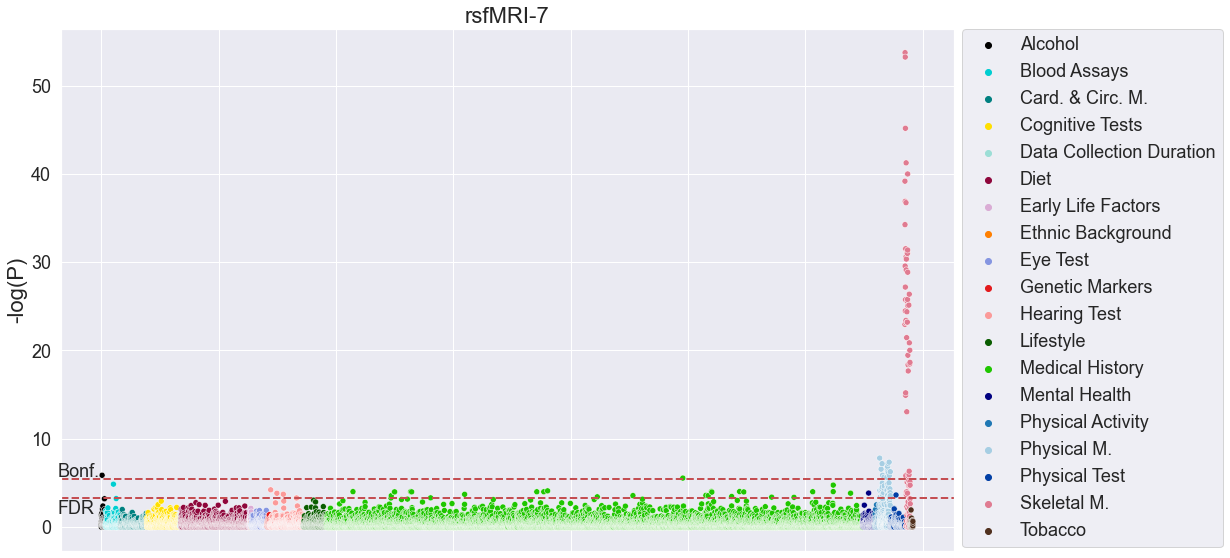

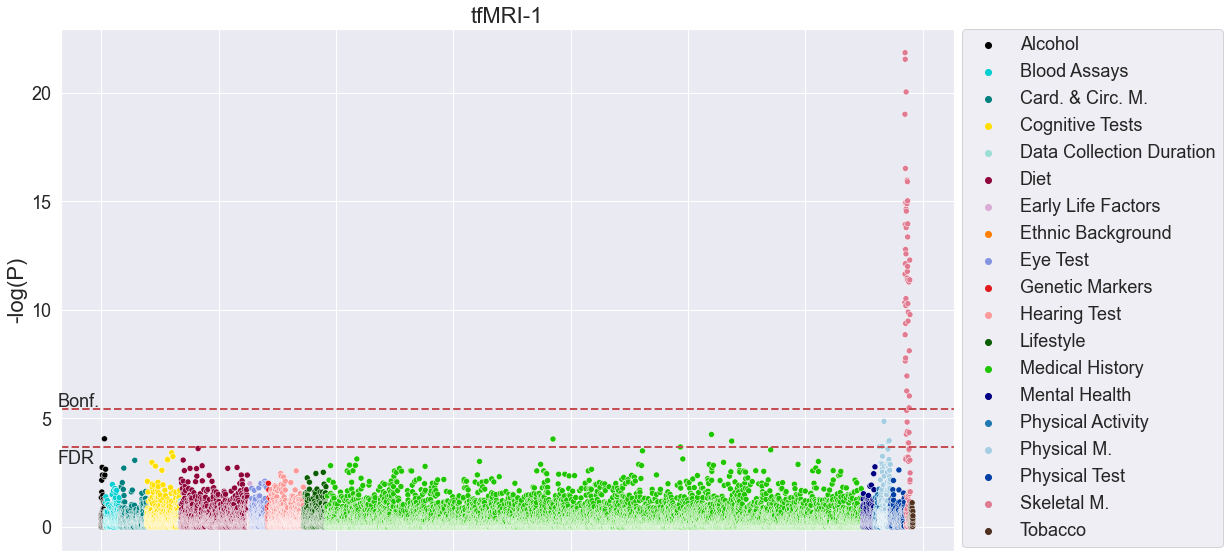

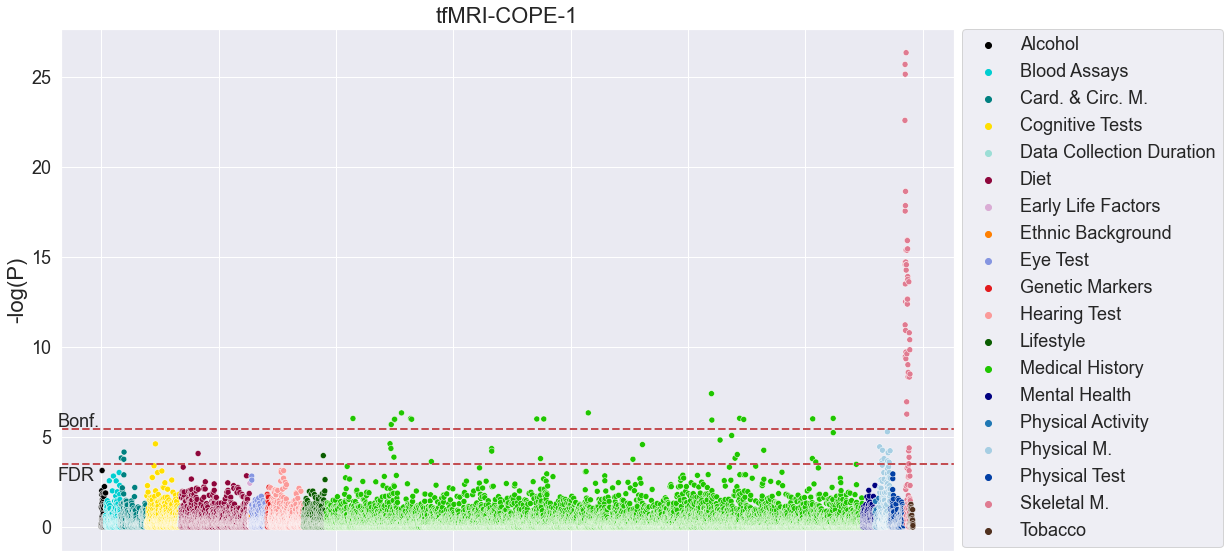

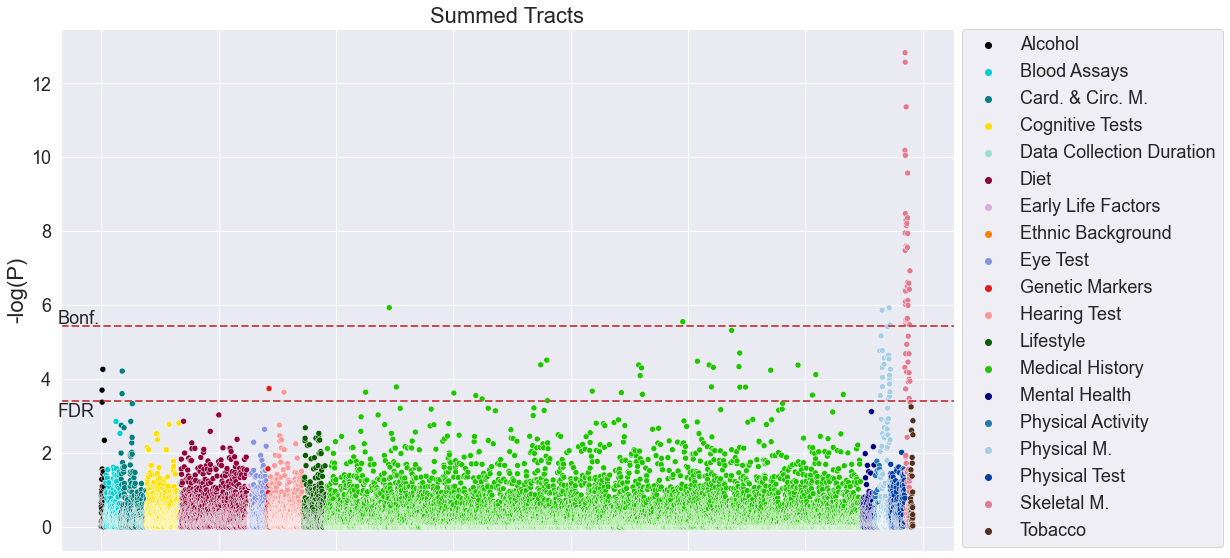

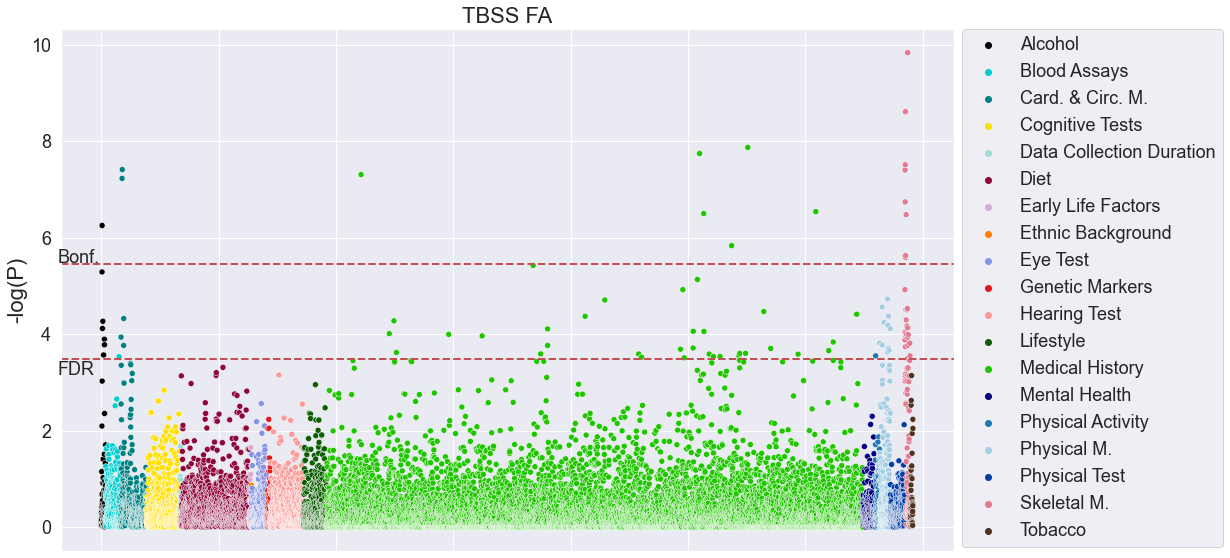

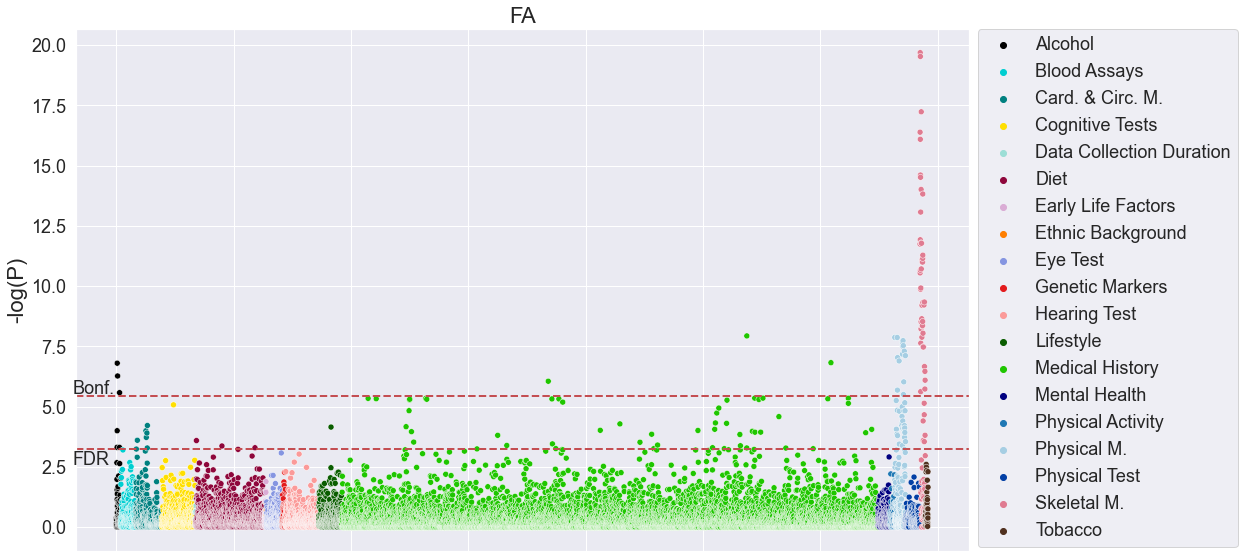

In [16]:
titles = [
    'T1 Nonlinear', 'T2 Nonlinear', 'T2 Lessions', 'SWI', 'rsfMRI-0', 
    'rsfMRI-3', 'rsfMRI-7', 'tfMRI-1', 'tfMRI-COPE-1',
    'Summed Tracts', 'TBSS FA', 'FA', 
]

modality_indexes = [0, 4, 5, 6, 7, 10, 14, 32, 35, 38, 39, 48]

save_title = 'Female_Manhattan_Plots'

title_font_size=22
ticks_font_size=18
legend_font = 18
figsize=(16, 9.6)

i = 0

for idx in modality_indexes:
    corr_df = df.iloc[idx].dataframe
    
    corr_df.loc[corr_df['Categories'] == 'Cardiac & Circulartory Measurements', 'Categories'] = 'Card. & Circ. M.'
    corr_df.loc[corr_df['Categories'] == 'Physical Measurements', 'Categories'] = 'Physical M.'
    corr_df.loc[corr_df['Categories'] == 'Skeletal Measurements', 'Categories'] = 'Skeletal M.'
    
    
    bonferroni_threshold = df.iloc[idx].bonf
    false_discovery_rate = df.iloc[idx].fdr
    title = df.iloc[idx].modality
    
    tmp_save_title = save_title + '_' + titles[i] + '.png'
    
    correlations_and_plots_replot(corr_df=corr_df, 
                                   bonferroni_threshold=bonferroni_threshold, 
                                   false_discovery_rate=false_discovery_rate,
                                   title=titles[i],
                                  figsize=figsize,
                                  ticks_font_size = ticks_font_size,
                                  title_font_size = title_font_size,
                                  legend_font = legend_font,
                                  save_title = tmp_save_title
                                  )

    i+=1

Female_Manhattan_Plots_Female Subjects: sMRI (T1 Nonlinear) - Phenotype Associations.png


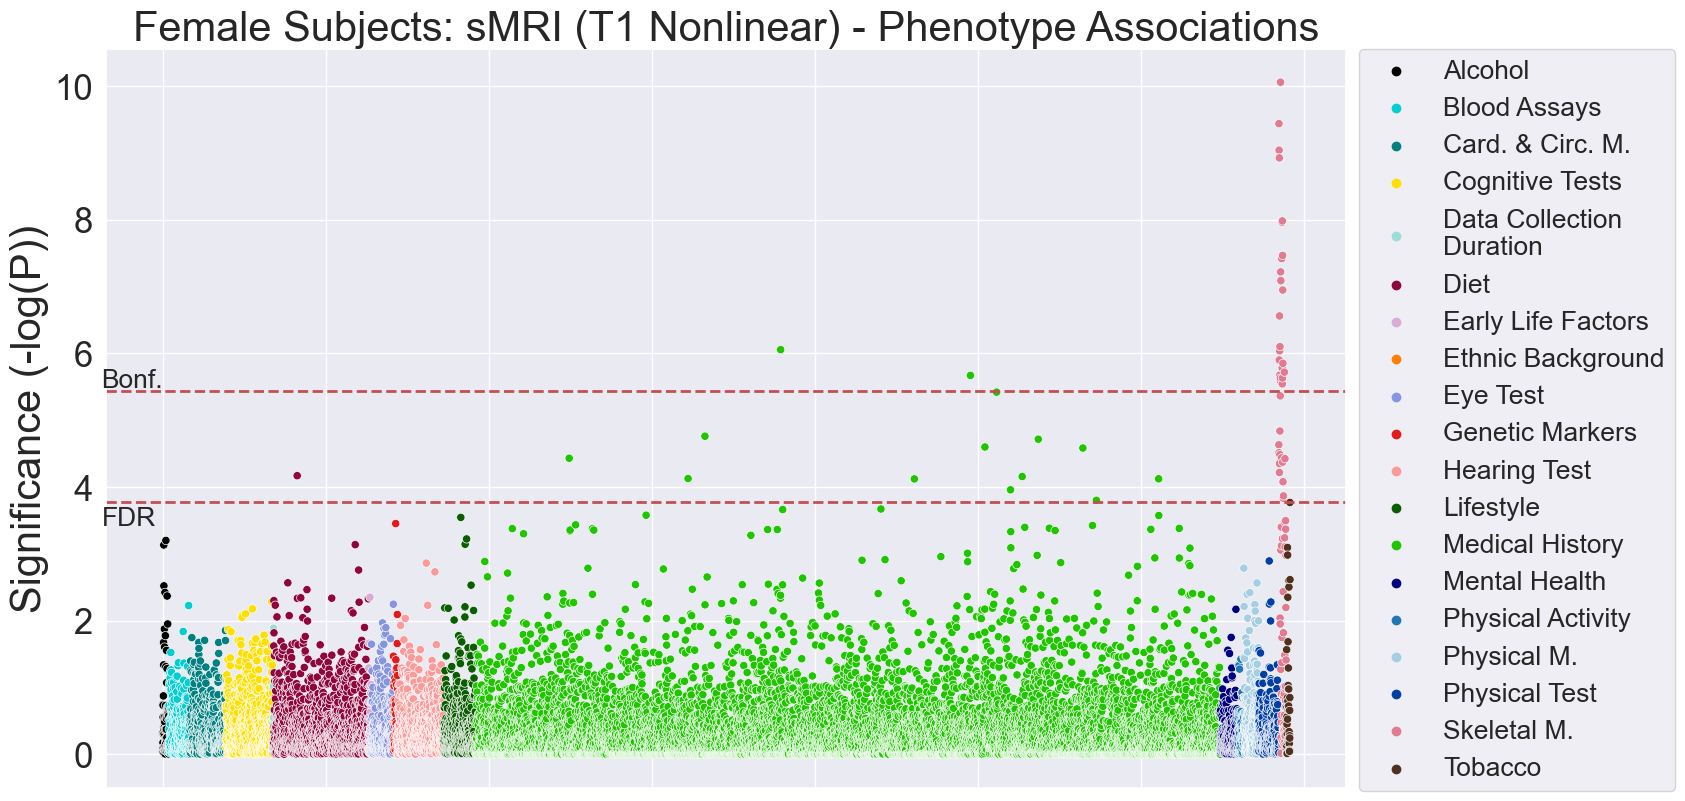

In [12]:
titles = [
    'Female Subjects: sMRI (T1 Nonlinear) - Phenotype Associations' 
]

modality_indexes = [0]

save_title = 'Female_Manhattan_Plots'

title_font_size=30
ticks_font_size=25
legend_font = 19
figsize=(16, 9.6)

i = 0

for idx in modality_indexes:
    corr_df = df.iloc[idx].dataframe
    
    corr_df.loc[corr_df['Categories'] == 'Cardiac & Circulartory Measurements', 'Categories'] = 'Card. & Circ. M.'
    corr_df.loc[corr_df['Categories'] == 'Physical Measurements', 'Categories'] = 'Physical M.'
    corr_df.loc[corr_df['Categories'] == 'Skeletal Measurements', 'Categories'] = 'Skeletal M.'
    corr_df.loc[corr_df['Categories'] == 'Data Collection Duration', 'Categories'] = 'Data Collection\nDuration'
    
    
    bonferroni_threshold = df.iloc[idx].bonf
    false_discovery_rate = df.iloc[idx].fdr
    title = df.iloc[idx].modality
    
    tmp_save_title = save_title + '_' + titles[i] + '.png'
    
    correlations_and_plots_replot(corr_df=corr_df, 
                                   bonferroni_threshold=bonferroni_threshold, 
                                   false_discovery_rate=false_discovery_rate,
                                   title=titles[i],
                                  figsize=figsize,
                                  ticks_font_size = ticks_font_size,
                                  title_font_size = title_font_size,
                                  legend_font = legend_font,
                                  save_title = tmp_save_title, 
                                  ylabel = 'Significance (-log(P))'
                                  )

    i+=1
    
    print(tmp_save_title)

Female_Manhattan_Plots_Female Subjects: sMRI (T1 Nonlinear) - Phenotype Associations.png


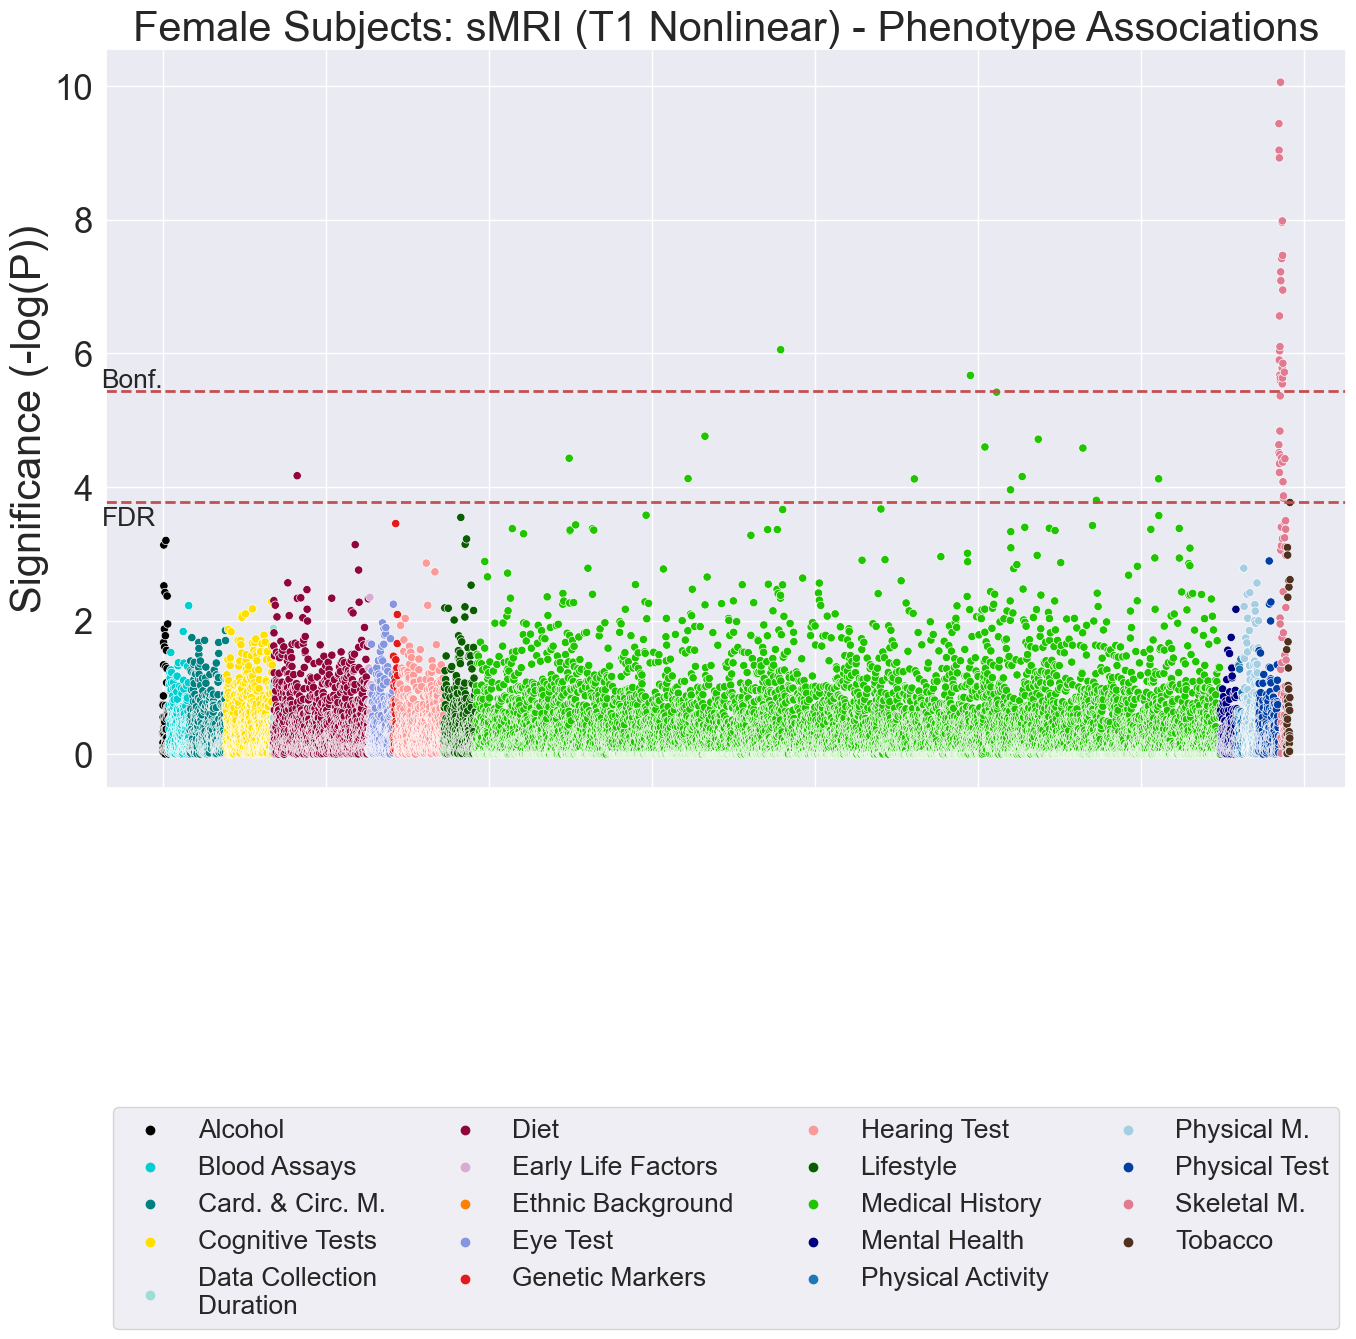

In [ ]:
titles = [
    'Female Subjects: sMRI (T1 Nonlinear) - Phenotype Associations' 
]

modality_indexes = [0]

save_title = 'Female_Manhattan_Plots'

title_font_size=30
ticks_font_size=25
legend_font = 19
figsize=(16, 9.6)

i = 0

for idx in modality_indexes:
    corr_df = df.iloc[idx].dataframe
    
    corr_df.loc[corr_df['Categories'] == 'Cardiac & Circulartory Measurements', 'Categories'] = 'Card. & Circ. M.'
    corr_df.loc[corr_df['Categories'] == 'Physical Measurements', 'Categories'] = 'Physical M.'
    corr_df.loc[corr_df['Categories'] == 'Skeletal Measurements', 'Categories'] = 'Skeletal M.'
    corr_df.loc[corr_df['Categories'] == 'Data Collection Duration', 'Categories'] = 'Data Collection\nDuration'
    
    
    bonferroni_threshold = df.iloc[idx].bonf
    false_discovery_rate = df.iloc[idx].fdr
    title = df.iloc[idx].modality
    
    tmp_save_title = save_title + '_' + titles[i] + '.png'
    
    correlations_and_plots_replot(corr_df=corr_df, 
                                   bonferroni_threshold=bonferroni_threshold, 
                                   false_discovery_rate=false_discovery_rate,
                                   title=titles[i],
                                  figsize=figsize,
                                  ticks_font_size = ticks_font_size,
                                  title_font_size = title_font_size,
                                  legend_font = legend_font,
                                  save_title = tmp_save_title, 
                                  ylabel = 'Significance (-log(P))',
                                  legend_ncol=4
                                  )

    i+=1
    
    print(tmp_save_title)

In [15]:
corr_df

idx                                              names  \
0          0                            Ethnic background (0.0)   
1          1                            Ethnic background (1.0)   
2          2                            Ethnic background (2.0)   
3          3                   Genotype measurement batch (0.0)   
4          4                               Heterozygosity (0.0)   
...      ...                                                ...   
13830  17507      Manifestations of mania or irritability (0.1)   
13831  17514                 Substances taken for anxiety (0.1)   
13832  17516       Activities undertaken to treat anxiety (0.1)   
13833  17525  Ever been offered/sought treatment for anxiety...   
13834  17526  Ever been offered/sought treatment for depress...   

              Categories  pearson_r  t_test_statistic  p_values_corrected  \
0      Ethnic Background  -0.025750          1.288945            1.000000   
1      Ethnic Background  -0.048177          0.997849            1.000000   
2      Ethnic Background  -0.060422          1.625376            0.904332   
3        Genetic Markers  -0.047453          2.351434            0.493020   
4        Genetic Markers  -0.001731          0.085683            1.000000   
...                  ...        ...               ...                 ...   
13830      Mental Health   0.031322          0.560589            1.000000   
13831      Mental Health   0.072784          1.319663            1.000000   
13832      Mental Health   0.045087          0.812392            1.000000   
13833      Mental Health  -0.024537          1.101487            1.000000   
13834      Mental Health  -0.014531          0.652187            1.000000   

       p_values  abs_pearson_r  log_p_values  log_p_values_corrected  
0      0.197536       0.025750      0.704353               -0.000000  
1      0.318916       0.048177      0.496323               -0.000000  
2      0.104519       0.060422      0.980803                0.043672  
3      0.018780       0.047453      1.726304                0.307136  
4      0.931725       0.001731      0.030712               -0.000000  
...         ...            ...           ...                     ...  
13830  0.575470       0.031322      0.239977               -0.000000  
13831  0.187871       0.072784      0.726141               -0.000000  
13832  0.417163       0.045087      0.379694               -0.000000  
13833  0.270816       0.024537      0.567325               -0.000000  
13834  0.514355       0.014531      0.288737               -0.000000  

[13835 rows x 10 columns]

In [ ]:
df_dct.loc[df_dct['var_name'] == 'Cardiac & Circulartory Measurements', 'var_name'] = 'Card. & Circ. M.'
df_dct.loc[df_dct['var_name'] == 'Physical Measurements', 'var_name'] = 'Physical M.'
df_dct.loc[df_dct['var_name'] == 'Skeletal Measurements', 'var_name'] = 'Skeletal M.'